Starting model training pipeline...
Using device: cpu

Loading datasets...
Loaded 15542 images for train split
Loaded 4943 images for val split
Dataset sizes: Train=15542, Validation=4943

=== TRAINING PHASE ===


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10: 100%|█████████████████| 486/486 [03:09<00:00,  2.57it/s, loss=0.655]


Epoch 1/10, Loss: 0.7995
Validation Accuracy: 0.7028
✅ New best model saved at epoch 1 with validation accuracy: 0.7028


Epoch 2/10: 100%|█████████████████| 486/486 [03:13<00:00,  2.52it/s, loss=0.232]


Epoch 2/10, Loss: 0.4002
Validation Accuracy: 0.9112
✅ New best model saved at epoch 2 with validation accuracy: 0.9112


Epoch 3/10: 100%|████████████████| 486/486 [03:21<00:00,  2.42it/s, loss=0.0318]


Epoch 3/10, Loss: 0.1541
Validation Accuracy: 0.9862
✅ New best model saved at epoch 3 with validation accuracy: 0.9862


Epoch 4/10: 100%|███████████████| 486/486 [03:12<00:00,  2.53it/s, loss=0.00164]


Epoch 4/10, Loss: 0.0611
Validation Accuracy: 0.9820


Epoch 5/10: 100%|████████████████| 486/486 [39:50<00:00,  4.92s/it, loss=0.0215]


Epoch 5/10, Loss: 0.0364
Validation Accuracy: 0.9951
✅ New best model saved at epoch 5 with validation accuracy: 0.9951


Epoch 6/10: 100%|███████████████| 486/486 [2:55:07<00:00, 21.62s/it, loss=0.065]


Epoch 6/10, Loss: 0.0323
Validation Accuracy: 0.9879


Epoch 7/10: 100%|█████████████| 486/486 [3:05:55<00:00, 22.95s/it, loss=0.00246]


Epoch 7/10, Loss: 0.0383
Validation Accuracy: 0.9939


Epoch 8/10: 100%|████████████████| 486/486 [03:05<00:00,  2.62it/s, loss=0.0124]


Epoch 8/10, Loss: 0.0193
Validation Accuracy: 0.9953
✅ New best model saved at epoch 8 with validation accuracy: 0.9953


Epoch 9/10: 100%|███████████████| 486/486 [03:10<00:00,  2.55it/s, loss=0.00206]


Epoch 9/10, Loss: 0.0240
Validation Accuracy: 0.9947


Epoch 10/10: 100%|█████████████| 486/486 [03:09<00:00,  2.56it/s, loss=0.000384]


Epoch 10/10, Loss: 0.0233
Validation Accuracy: 0.9860

Training completed. Best model was from epoch 8 with validation accuracy: 0.9953
Final model saved to Processed_MRI_Dataset/models/final_model.pt

Generating training curves plot...


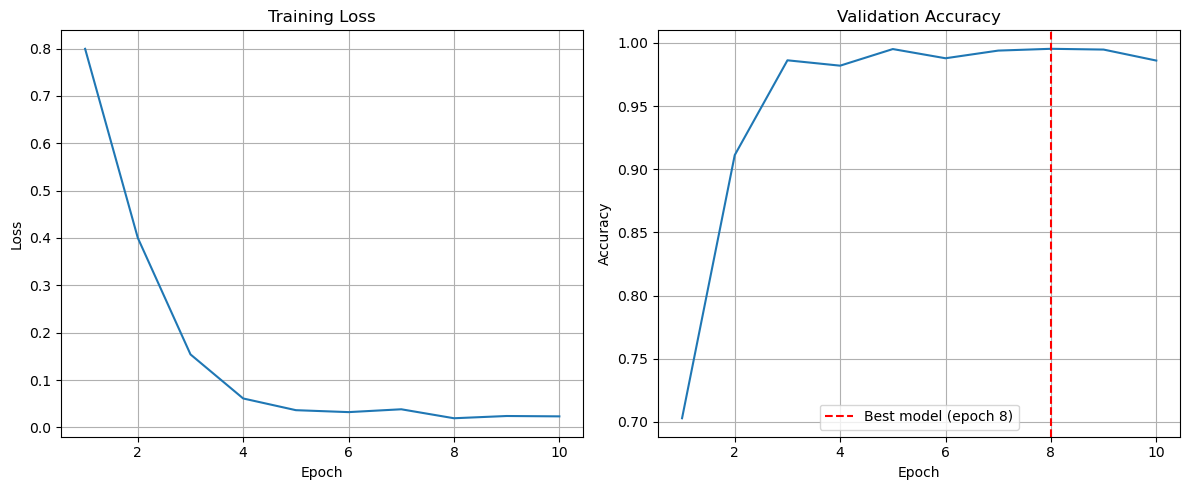


Training complete!
Best model was from epoch 8 with validation accuracy: 0.9953


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF

N_CLASSES = 4  # Mild_Demented(0), Moderate_Demented(1), Non_Demented(2), Very_Mild_Demented(3)
CLASS_NAMES = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

processed_output_dir = "Processed_MRI_Dataset"

os.makedirs(os.path.join(processed_output_dir, "models"), exist_ok=True)
os.makedirs(os.path.join(processed_output_dir, "plots"), exist_ok=True)

# Custom Dataset class for processed ventricle images
class VentricleDataset(Dataset):
    def __init__(self, base_dir, split='train'):
        self.base_dir = base_dir
        self.split = split
        
        # Class mapping
        self.classes = {
            'Mild_Demented': 0,
            'Moderate_Demented': 1,
            'Non_Demented': 2,
            'Very_Mild_Demented': 3
        }
        
        self.data_dir = os.path.join(base_dir, split)
        
        self.images = []
        self.labels = []
        
        # Process each class folder
        for class_name, label in self.classes.items():
            class_dir = os.path.join(self.data_dir, class_name)
            
            if not os.path.exists(class_dir):
                print(f"Warning: Class directory {class_dir} does not exist")
                continue
                
            # Process each image in the class folder
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith('ventricle.png'):
                    img_path = os.path.join(class_dir, img_file)
                    self.images.append(img_path)
                    self.labels.append(label)
        
        print(f"Loaded {len(self.images)} images for {split} split")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Get image path and label
        img_path = self.images[idx]
        label = self.labels[idx]
        
        img = Image.open(img_path)
        
        # Convert image to tensor
        img_tensor = TF.to_tensor(img)
        
        return img_tensor, torch.tensor(label, dtype=torch.long)

class VentricleCNN(nn.Module):
    def __init__(self, input_channels=1, input_size=(128, 128)):
        super(VentricleCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(64)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.batchnorm3 = nn.BatchNorm2d(128)
        
        # Fourth convolutional block for deeper features
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        # Calculate feature dimensions after pooling
        # After 4 pooling layers of 2x2, dimensions are reduced by factor of 16
        reduced_h = input_size[0] // 16
        reduced_w = input_size[1] // 16
        self.fc_input_size = 256 * reduced_h * reduced_w
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.out = nn.Linear(128, N_CLASSES)
        
    def forward(self, x):
        # First block
        x = self.batchnorm1(self.pool1(F.relu(self.conv1(x))))
        
        # Second block
        x = self.batchnorm2(self.pool2(F.relu(self.conv2(x))))
        
        # Third block
        x = self.batchnorm3(self.pool3(F.relu(self.conv3(x))))
        
        # Fourth block
        x = self.pool4(F.relu(self.conv4(x)))
        
        # Fully connected layers
        x = self.flatten(x)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.out(x)
        
        return x

# Evaluation function (needed for validation during training)
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return accuracy

# Training function to save the best model based on validation accuracy
def train_model(model, train_loader, val_loader=None, num_epochs=15, learning_rate=0.001, save_dir=None):
    if save_dir is None:
        save_dir = "."  # Default to current directory
        
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    train_losses = []
    val_accuracies = []
    
    # For tracking best model
    best_val_acc = 0.0
    best_model_state = None
    best_epoch = 0
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for i, data in enumerate(progress_bar):
            # Get the inputs and labels
            inputs, labels = data
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Update running loss
            running_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        
        # Evaluate on validation set if provided
        if val_loader:
            val_acc = evaluate_model(model, val_loader)
            val_accuracies.append(val_acc)
            print(f'Validation Accuracy: {val_acc:.4f}')
            
            # Check if this is the best model so far
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict().copy()
                best_epoch = epoch + 1
                
                # Save the best model 
                best_model_path = os.path.join(save_dir, "best_model.pt")
                torch.save({
                    'epoch': best_epoch,
                    'model_state_dict': best_model_state,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'validation_accuracy': best_val_acc,
                }, best_model_path)
                
                print(f"✅ New best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.4f}")
            
            # Update learning rate based on validation performance
            scheduler.step(epoch_loss)
    
    print(f"\nTraining completed. Best model was from epoch {best_epoch} with validation accuracy: {best_val_acc:.4f}")
    
    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_accuracies, best_epoch, best_val_acc

def training_pipeline():
    img_size = (128, 128) # might up to 256
    batch_size = 32
    num_epochs = 10
    learning_rate = 0.001
    
    models_dir = os.path.join(processed_output_dir, "models")
    plots_dir = os.path.join(processed_output_dir, "plots")
    
    # Load the processed datasets
    print("\nLoading datasets...")
    train_dataset = VentricleDataset(base_dir=processed_output_dir, split='train')
    val_dataset = VentricleDataset(base_dir=processed_output_dir, split='val')
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    print(f"Dataset sizes: Train={len(train_dataset)}, Validation={len(val_dataset)}")
    
    # Create and train the model
    print("\n=== TRAINING PHASE ===")
    model = VentricleCNN(input_size=img_size)
    
    model, train_losses, val_accuracies, best_epoch, best_val_acc = train_model(
        model, train_loader, val_loader, num_epochs, learning_rate, save_dir=models_dir
    )
    
    # Plot training curves
    print("\nGenerating training curves plot...")
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies)
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best model (epoch {best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "training_curves.png"))
    plt.show()
    
    print("\nTraining complete!")
    print(f"Best model was from epoch {best_epoch} with validation accuracy: {best_val_acc:.4f}")
    
    return model, best_val_acc

def main():
    print("Starting model training pipeline...")
    training_pipeline()

if __name__ == "__main__":
    main()